<a href="https://colab.research.google.com/github/apoorvaa30/RL/blob/main/RL_Project_Dec_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Title: Pricing American Options using Reinforcement Learning**

**Introduction:** 

An option is the right but not the obligation that the buyer/seller holds to buy/sell the underlying asset (let its price at exercise date t be S_t) specified in the option at some future date (option exercise or maturity date, t), at a pre-determined price (strike of the option, K). Let the contract entry date be t_0. 

Option can be of two main types:
1. Put option: max(S_t - K, 0)
2. Call option: max(K - S_t, 0)

Other types of options are also available (cap, floor, collar, barrier, digital, etc.), however, we do not consider these for the purpose of this exercise.

Based on the number of scheduled exercise dates as agreed upon in the option contract, options are found in the following flavours:
1. European: one exercise date
2. American: can be exercised on all dates between t_0 and t
3. Bermudan: between European and American, number of exercises dates is more than 1 and less than (t-t_0)

Pricing European options (whether put or call) is an analytically tractable problem, with various closed form models available. However, pricing American options is slightly more complex due to the computation cost involved. Based on the underlying option type, the problem of pricing American options becomes even more complex - eg: in case of barrier American options.

In this document, we compare the price for American options obtained with current industry standard algorithms, versus reinforcement learning based approach as described in Li, Szepesvari, Schuurmans' paper [2].

In [ ]:
 
try:
  import QuantLib as ql 
except:
  !pip install QuantLib-Python
  import QuantLib as ql

import pandas as pd
import numpy as np
import gym
import matplotlib.pyplot as plt

     |████████████████████████████████| 18.8MB 47.1MB/s 


In [ ]:
'''Creating american option'''

# option parameters
maturity = ql.Date(31, 12, 2021)

S0 = 100
K = 100
r = 0.02
sigma = 0.20
d =  0.0

dc = ql.Actual365Fixed() #day count convention for present value calculation
calendar = ql.NullCalendar() #default business day calendar for interest accumulation

today = ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = today

N = (maturity - today)//365 # option maturity in years, assuming days in years = 365
print(N)

3


In [ ]:
# option type
otype1 = ql.Option.Put
otype2 = ql.Option.Call

payoff = ql.PlainVanillaPayoff(otype1, K)
#payoff = ql.PlainVanillaPayoff(otype2, K)

In [ ]:
# payoff with exercise flavour
european_exercise = ql.EuropeanExercise(maturity)
european_option = ql.VanillaOption(payoff, european_exercise)

american_exercise = ql.AmericanExercise(today, maturity)
american_option = ql.VanillaOption(payoff, american_exercise)

In [ ]:
#Discount factors, interest rate, vol
#Case 1: constant/normal vol surface
d_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, d, dc))
r_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, dc))
sigma_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, calendar, sigma, dc))
bsm_process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(S0)), d_ts, r_ts, sigma_ts)

#Case 2: vol with smile
# to do

In [ ]:
#Baseline output price from industry standard models for case 1 with put option
pricing_dict = {}

#1 Black Scholes model
bsm73 = ql.AnalyticEuropeanEngine(bsm_process)
european_option.setPricingEngine(bsm73)
pricing_dict['BlackScholesEuropean'] = european_option.NPV()

#2 Barone-Adesi Whaley Approximation model
analytical_engine = ql.BaroneAdesiWhaleyApproximationEngine(bsm_process)
american_option.setPricingEngine(analytical_engine)
pricing_dict['BawApproximation'] = american_option.NPV()

#3 Binomial Tree model
binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", 100)
american_option.setPricingEngine(binomial_engine)
pricing_dict['BinomialTree'] = american_option.NPV()

#4 Black Scholes via Finite Difference methods
fd_engine = ql.FdBlackScholesVanillaEngine(bsm_process)
american_option.setPricingEngine(fd_engine)
pricing_dict['FiniteDifference'] = american_option.NPV()

In [ ]:
#5 Longstaff-Schwartz Least Squares Monte Carlo model
# takes significant time to run at currently set params !!!

trait = "pseudorandom" # "lowdiscrepancy"
ls_engine = ql.MCAmericanEngine(bsm_process, trait, 10000, None, False, False, 1000, 0.02, 700000)
american_option.setPricingEngine(ls_engine)
pricing_dict['LongstaffSchwartz'] = american_option.NPV()

In [ ]:
base_prices = pd.DataFrame.from_dict(pricing_dict, orient='index', columns=['Option_Price'] ) 
base_prices = base_prices.assign( Premium_wrt_European =  [x - pricing_dict['BlackScholesEuropean']  for x in pricing_dict.values()])

print(pricing_dict)
print(base_prices)

{'BlackScholesEuropean': 10.63650220227224, 'BawApproximation': 11.29814768688012, 'BinomialTree': 11.261873670954653, 'FiniteDifference': 11.267101205311281}
                      Option_Price  Premium_wrt_European
BlackScholesEuropean     10.636502              0.000000
BawApproximation         11.298148              0.661645
BinomialTree             11.261874              0.625371
FiniteDifference         11.267101              0.630599


In [ ]:
'''Option Pricing Environment + Simulation Model for Stock Prices (GBM)'''

# let max possible stock price be 1000, and min possible stock price be 0. Ideally, s_high should be taken to be np.inf
s_high = 1000

class AmeriOptionEnv(gym.Env):
    def __init__(self):
        self.S0 = S0 #100.0
        self.K = K #100.0
        self.r = r #0.02
        self.sigma = sigma #0.20
        self.T = 1.0
        self.N = N*365    # here, N = option maturity in years, N*365 is number of days till maturity

        self.S1 = 0
        self.reward = 0
        self.day_step = 0    # from day 0 taking N steps to day N*365

        self.action_space = gym.spaces.Discrete(2)         # 0: hold, 1:exercise
        self.observation_space = gym.spaces.Box(low=np.array([0, 0]), high=np.array([s_high, N]), dtype=np.float32)      # S in [0, inf], tao in [0, N]

    def step(self, action):
        if action == 1:        # exercise
            reward = max(K-self.S1, 0.0) * np.exp(-self.r * self.T * (self.day_step/self.N))
            done = True
        else:       # hold
            if self.day_step == self.N:    # at maturity
                reward = max(self.K-self.S1, 0.0) * np.exp(-self.r * self.T)
                done = True
            else: # move to tomorrow
                reward = 0
                self.S1 = self.S1 * np.exp((self.r - 0.5 * self.sigma**2) * (self.T/self.N) + self.sigma * np.sqrt(self.T/self.N) * np.random.normal())
                self.day_step += 1
                done = False

        tao = 1.0-self.day_step/self.N        # time to maturity, in unit of years
        return np.array([self.S1, tao]), reward, done, {}

    def reset(self):
        self.day_step = 0
        self.S1 = self.S0
        tao = 1.0-self.day_step/self.N        # time to maturity, in unit of years
        return [self.S1, tao]
    
    def render(self):
        """
        make video
        """
        pass

    def close(self):
        pass

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


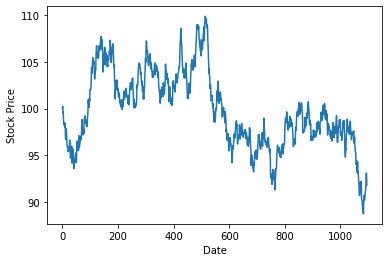

In [ ]:
# Plot stock prices using the environment created above

env = AmeriOptionEnv()
s = env.reset()

sim_prices = []
sim_prices.append(s[0])
for i in range(365*N):
  action = 0
  s_next, reward, done, info = env.step(action)
  sim_prices.append(s_next[0])

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(sim_prices)

**Problem formulation under Least Square Policy Iteration:**

SP = simulation paths of underlying security process SP[i,j] - price at j, for given path i

CF = PV of current + future cash flow, for each path i

states[i,j] = [tau[j], SP[i, :(j+1)]] = current time + price history, for given path i

payoff[i,j] = put on SP

r = 7, based on feature function chosen

phi (0 to r-1) = feature functions of states[i,j]

weight (0 to r-1) = regression weights

regression function f(payoff[i,j]) = wT*phi(payoff[i,j])

f(.) = estimate of continuation value for in the money states

state = [current time, underlying security prices history] = same as above, is a tuple

action = exercise or continue (1, 0)

reward = 0 on continue, payoff value on exercise


In [ ]:
#@title Hyperparameters
m = 10000 #@param {type:"integer"} #Monte Carlo paths
batch_size = 500 #@param {type:"integer"}

n = N*365 #timesteps, number of days
matrix_size = 7 #based on feature function used




In [ ]:
# Simulate stock price paths - m*n matrix

env = AmeriOptionEnv()
s = env.reset()
SP = list()
t = list()
for i in range(5000):
  sim_prices = []
  sim_times = []
  sim_prices.append(s[0])
  sim_times.append(s[1])
  for j in range(n):
    action = 0
    s_next, reward, done, info = env.step(action)
    sim_prices.append(s_next[0])
    sim_times.append(s_next[1])
  SP.append(sim_prices)
  t.append(sim_times)

def american_payoff(S1, T):
  S1 = S1 * np.exp((r - 0.5 * sigma**2) * (T/N) + sigma * np.sqrt(T/N) * np.random.normal())
  return S1

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
def phi_S(sp):
  '''Laguerre polynomials used here for SP[i, :j+1]'''
  S_div = sp/K
  phi = np.zeros(shape = 4)
  phi[0] =  1 
  phi[1] = ( np.exp(-np.power(S_div,2) ) )
  phi[2] = ( phi[1]*(1-S_div) )
  phi[3] = ( phi[1]*( 1 - 2*S_div + (np.power(S_div,2)/2 ) ) )
  return phi

def phi_T(j):
  '''Laguerre polynomials used here for t[j]'''
  phi = np.zeros(shape = 3)
  T = N
  phi[0]= ( np.sin( ( np.pi*(T-j) )/(2*T) ) )
  phi[1]= ( np.log( (T-j) ) )
  phi[2]= ( np.power( (j/T), 2 ) )
  return phi

In [ ]:
'''Reinforcement Learning Algorithm Implementation'''
# LSPI

def LSPIAmericanPricing(env, SP, MC_paths, time_steps, batch_size):
  A = np.zeros(shape = (matrix_size, matrix_size))
  B = np.zeros(shape = matrix_size)
  w = np.zeros(shape = matrix_size)

  all_rewards = []
  avg_reward = 0
  rewards = []

  # Algorithm
  for i in range(0,MC_paths):
    for j in range(0,time_steps):
      sp = SP[i][j]
      sp_next = SP[i][(j+1)]

      Q = american_payoff(sp_next, j+1)

      ps = phi_S(sp) 
      pt = phi_T(j-1)
      phi_sp = np.concatenate((ps, pt), axis = 0)
      ps1 = phi_S(sp_next)
      pt1 = phi_T(j)
      phi_sp_next = np.concatenate((ps1, pt1), axis = 0)

      # print(w.T)
      # print(phi_sp_next)
      if j < n-1 and Q <= np.matmul( np.matrix(w), np.matrix(phi_sp_next).T ) :
        P = phi_sp_next
      else:
        P = np.zeros(7)
      if Q > np.matmul( np.matrix(w), np.matrix(P).T ):
        R = Q
      else:
        R = 0
      tx = t[i][j]
      ty = t[i][j+1]
      
      z = -r*(ty-tx)
      
      x = np.array(np.exp(z)*P.T)
      c = np.array(phi_sp)
      y = list( c-x)
      
      A = A + np.matmul( phi_sp, list( y ) )
      B = B + np.exp(-r*(ty-tx))*(R*phi_sp)
      rewards.append(R)

    if (i+1)%batch_size == 0: # for all batches of given MC path
      try:
        w = numpy.linalg.inv(A)*B
      except:
        pass
    avg_reward = np.mean(rewards)
    rewards = []
    if (i+1) == MC_paths: #collect batch rewards series for all MC paths
      all_rewards.append(avg_reward)
      avg_reward = []
    
    A = np.zeros(shape = (matrix_size, matrix_size))
    B = np.zeros(shape = matrix_size) 
    
    
    env.reset()

  return Q, R, all_rewards

In [ ]:
Q, R, all_rewards = LSPIAmericanPricing(env, SP, MC_paths=m, time_steps=n, batch_size=1)
print(Q)
print(R)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in matmul
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


232.690796968207
232.690796968207


In [ ]:
pricing_dict['LSPIAmerican'] = Q
base_prices = pd.DataFrame.from_dict(pricing_dict, orient='index', columns=['Option_Price'] ) 
base_prices = base_prices.assign( Premium_wrt_European =  [x - pricing_dict['BlackScholesEuropean']  for x in pricing_dict.values()])

print(pricing_dict)
print(base_prices)

**Key Takeaways:**

Given reasonable compute and number of MC paths, the Longstaff-Schwartz and the LSPI are expected to give similar results


**Further Directions:**

The exercise above can be improved in the following ways:
1. Implement for other option types, like barriers
2. Implement for non-constant vol surface with smile
3. Derive greeks from reinforcement learning based implementation. Sensitivity of option price to various input processes is relatively straightforward to obtain using classical option pricing methods. This is not the case for Reinforcement Learning based approaches, where computing greeks via bruteforce may incur significant compute resources.

**References:**

Option Pricing Theory:
1. Pricing American Options with Reinforcement Learning, Ashwin Rao (http://web.stanford.edu/class/cme241/lecture_slides/AmericanOptionsRL.pdf)
2. Learning Exercise Policies for American Options, Yuxi Li et al (http://proceedings.mlr.press/v5/li09d/li09d.pdf)
3. Stochastic Calculus, Volume II, Steven Shreve
4. Mathematical Finance, Mark Joshi

Python Implementation:
4. Quantlib for option pricing (section 1 above): American Option Pricing with QuantLib and Python, Goutham Balaraman (http://gouthamanbalaraman.com/blog/american-option-pricing-quantlib-python.html)
5. Gym Environment set-up (section 2 above): Option Pricing using Reinforcement Learning, Letian Wang (https://letianzj.github.io/)
6. Q-Learning in Python (https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/ ; https://towardsdatascience.com/getting-started-with-reinforcement-learning-and-open-ai-gym-c289aca874f)